## Data Source
<a href='https://www.kaggle.com/datasets/kazanova/sentiment140'>Kaggle Twitter Sentiment Dataset</a>

## Data Analysis

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('data/tweets.csv',names=['label','id','date','status','user','text'])

In [3]:
df.head()

,label,id,date,status,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df = df[['text','label']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   label   1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [6]:
df['label'].value_counts()

label
0    800000
4    800000
Name: count, dtype: int64

In [7]:
df['label'] = df['label'].apply(lambda label: 'Positive' if label else 'Negative')

In [8]:
df.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Negative
1,is upset that he can't update his Facebook by ...,Negative
2,@Kenichan I dived many times for the ball. Man...,Negative
3,my whole body feels itchy and like its on fire,Negative
4,"@nationwideclass no, it's not behaving at all....",Negative


## Data Visualization

In [9]:
import seaborn as sns

<Axes: xlabel='label', ylabel='count'>

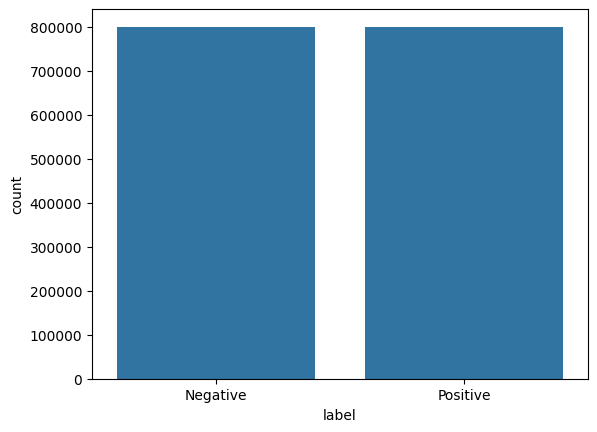

In [10]:
sns.countplot(x='label',data=df)

## Preprocessing

In [11]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

In [12]:
stopwords = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
noise = "https?://[^\s]+|@([A-Za-z0-9_]{1,15})|[^A-Za-z0-9]+"

In [13]:
def noisefree(text: str) -> str:
    alphanum = re.sub(noise,' ',text.lower())
    tokens = [stemmer.stem(word) for word in alphanum.split() if word not in stopwords]
    return ' '.join(tokens)

In [14]:
df['text'] = df['text'].apply(noisefree)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
training_set, testing_set = train_test_split(df,test_size=0.1)

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer

/Users/souviksarkar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

In [19]:
X_train = tokenizer.texts_to_sequences(training_set['text'])
X_test = tokenizer.texts_to_sequences(testing_set['text'])

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
X_train = pad_sequences(X_train,maxlen=35)
X_test = pad_sequences(X_test,maxlen=35)

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
encoder = LabelEncoder()
encoder.fit(training_set['label'])

LabelEncoder()

In [24]:
y_train = encoder.transform(training_set['label'])
y_test = encoder.transform(testing_set['label'])

In [25]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [26]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1440000, 35) (160000, 35) (1440000, 1) (160000, 1)


## Word Embedding

In [27]:
from gensim.models import Word2Vec

In [28]:
corpus = df['text'].apply(lambda text: text.split())

In [29]:
embedding_model = Word2Vec(sentences=corpus,vector_size=100,window=5,min_count=1,workers=5)
embedding_model.save('word_embedding.model')

In [30]:
vector = embedding_model.wv
embedding = [vector[word] if word in vector else [0]*100 for word in tokenizer.word_index]
embedding.insert(0,[0]*100)
embedding = np.array(embedding)

## Training

In [31]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Dropout

In [45]:
input_layer = Input(shape=(35,),dtype='int32')

In [46]:
hidden_layer = Embedding(
    input_dim=len(embedding),
    output_dim=100,
    weights=[embedding],
    trainable=False
)(input_layer)

In [47]:
hidden_layer = SpatialDropout1D(rate=0.2)(hidden_layer)

In [48]:
hidden_layer = Conv1D(
    filters=64,
    kernel_size=5,
    activation='relu'
)(hidden_layer)

In [49]:
hidden_layer = Bidirectional(LSTM(
    units=64,
    dropout=0.2,
    recurrent_dropout=0.2
))(hidden_layer)

In [50]:
hidden_layer = Dense(units=512,activation='relu')(hidden_layer)

In [51]:
hidden_layer = Dropout(rate=0.5)(hidden_layer)

In [52]:
hidden_layer = Dense(units=512,activation='relu')(hidden_layer)

In [53]:
output_layer = Dense(units=1,activation='sigmoid')(hidden_layer)

In [54]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [55]:
model = Model(input_layer,output_layer)
model.compile(
    optimizer=Adam(learning_rate=10**-2),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [56]:
reduce = ReduceLROnPlateau(
    factor=0.1,
    min_lr=10**-5,
    monitor='val_loss',
    verbose=2
)

In [57]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=512,
    epochs=5,
    validation_data=(X_test,y_test),
    callbacks=[reduce]
)

Epoch 1/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 343s 121ms/step - accuracy: 0.7174 - loss: 0.5551 - val_accuracy: 0.7579 - val_loss: 0.4948 - learning_rate: 0.0100
Epoch 2/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 355s 126ms/step - accuracy: 0.7451 - loss: 0.5134 - val_accuracy: 0.7566 - val_loss: 0.4936 - learning_rate: 0.0100
Epoch 3/5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 353s 125ms/step - accuracy: 0.7480 - loss: 0.5096 - val_accuracy: 0.7577 - val_loss: 0.4929 - learning_rate: 0.0100
Epoch 4/5
 222/2813 ━━━━━━━━━━━━━━━━━━━━ 5:01 117ms/step - accuracy: 0.7469 - loss: 0.5103

KeyboardInterrupt: 

In [45]:
model.save('lstm_model.keras')

## Evaluation

In [44]:
from sklearn.metrics import classification_report

In [47]:
predictions = model.predict(X_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [48]:
predictions = predictions.reshape(-1) >= 0.5
y_test = y_test.reshape(-1)

In [49]:
classification_report(y_test,predictions)

Test Accuracy: 49.24%
